# Solving (Set) Constraints in B and Event-B #
Michael Leuschel,
David Geleßus (Jupyter Interface)

## A quick Introduction to B ##

### Basic Datavalues in B ###

B provides the booleans, strings and integers as built-in datatypes. (Strings are not available in Event-B.)

In [1]:
BOOL

$\{\mathit{FALSE},\mathit{TRUE}\}$

In [2]:
"this is a string"

$\text{"this is a string"}$

In [3]:
1024

$1024$

Users can define their own datatype in a B machine.
One distinguishes between explicitly specified enumerated sets and deferred sets.

In [3]:
::load
MACHINE MyBasicSets
SETS Trains = {thomas, gordon}; Points
END

Loaded machine: MyBasicSets

For animation and constraint solving purposes, ProB will instantiate deferred sets to some finite set (the size of which can be controlled and is partially inferred).

In [4]:
Points

$\{\mathit{Points1},\mathit{Points2}\}$

### Pairs ###
B also has pairs of values, which can be written in two ways:

In [7]:
(thomas,10)

$(thomas\mapsto10)$

In [8]:
thomas |-> 10

$(thomas\mapsto10)$

Tuples simply correspond to nested pairs:

In [5]:
(thomas |-> gordon |-> 20)

$((\mathit{thomas}\mapsto \mathit{gordon})\mapsto 20)$

Classical B also provides records:

In [10]:
:prettyprint r=rec(train:thomas,length:20,position:10302)

r = rec(length:20,position:10302,train:thomas)

### Sets ###
Sets in B can be specified in multiple ways.
For example, using explicit enumeration:

In [11]:
{1,3,2,3}

$\{1,2,3\}$

or via a predicate by using a set comprehension:

In [12]:
{x|x>0 & x<4}

$\{1,2,3\}$

For integers there are a variety of other sets, such as intervals:

In [14]:
1..3

$\{1,2,3\}$

or the set of implementable integers INT = MININT..MAXINT or the set of implementable natural numbers NAT = 0..MAXINT.

Sets can be higher-order and contain other sets:

In [14]:
{ 1..3,  {1,2,3,2}, 0..1, {x|x>0 & x<4} }

$\{\{0,1\},\{1,2,3\}\}$

Relations are modelled as sets of pairs:

In [15]:
{ thomas|->gordon, gordon|->gordon, thomas|->thomas}

$\{(\mathit{thomas}\mapsto \mathit{thomas}),(\mathit{thomas}\mapsto \mathit{gordon}),(\mathit{gordon}\mapsto \mathit{gordon})\}$

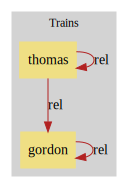

In [28]:
:dot expr_as_graph ("rel",{ thomas|->gordon, gordon|->gordon, thomas|->thomas})

Note: a pair is an element of a Cartesian product, and a relation is just a subset of a Cartesian product.
The above relation is a subset of ```Trains * Trains```.

Functions are relations which map every domain element to at most one value:

In [18]:
{ thomas|->1, gordon|->2}

$\{(thomas\mapsto1),(gordon\mapsto2)\}$

## Expressions vs Predicates vs Substitutions ##


### Expressions ###
Expressions in B have a value. With ProB and with ProB's Jupyter backend, you can evaluate expresssions such as:

In [18]:
2**1000

$10715086071862673209484250490600018105614048117055336074437503883703510511249361224931983788156958581275946729175531468251871452856923140435984577574698574803934567774824230985421074605062371141877954182153046474983581941267398767559165543946077062914571196477686542167660429831652624386837205668069376$

B provides many operators which return values, such as the usual arithmetic operators but also many operators for sets, relations and functions.
For example set union and set difference:

In [19]:
(1..3 \/ 5..10) \ (2..6)

$\{1,7,8,9,10\}$

In [20]:
(1..3 ∪ 5..10) \ (2..6)

$\{1,7,8,9,10\}$

The range of a relation or function:

In [22]:
dom({(thomas↦1),(gordon↦2)})

$\{thomas,gordon\}$

Function application:

In [21]:
{(thomas↦1),(gordon↦2)} (thomas)

$1$

Relational inverse (.~) and relational image .[.] :

In [22]:
{(thomas↦1),(gordon↦2)}~[2..3]

$\{\mathit{gordon}\}$

## Predicates
ProB can also be used to evaluate predicates (B distinguishes between expressions which have a value and predicates which are either true or false).

In [25]:
2>3

$FALSE$

In [26]:
3>2

$TRUE$

Within predicates you can use **open** variables, which are implicitly existentially quantified.
ProB will display the solution for the open variables, if possible.

In [23]:
x*x=100

$\mathit{TRUE}$

**Solution:**
* $\mathit{x} = -10$

We can find all solutions to a predicate by using the set comprehension notation.
Note that by this we turn a predicate into an expression.

In [24]:
{x|x*x=100}

$\{-10,10\}$

### Substitutions ###
B also has a rich syntax for substitutions, aka statements.
For example ```x := x+1``` increments the value of x by 1.
We will not talk about substitutions in the rest of this presentation.
The major differences between classical B and Event-B lie in the area of substitutions, machine composition and refinement.

## Definition of Constraint Solving ##

Constraint solving is determine whether a predicate with open/existentially quantified variables is satisfiable and providing values for the open variables in case it is.
We have already solved the predicate ```x*x=100``` above, yielding the solution ```x=-10```.
The following is an unsatisfiable predicate:

In [29]:
:prettyprint #x.(x:NATURAL & x*x=1000)

∃x·(x ∈ ℕ ∧ x * x = 1000)

The difference to **proof** is that in constraint solving one has to produce a solution (aka a model). The difference to **execution** is that not all variables are known.

## Constraint Solving Applications ##
Constraint solving has many applications in formal methods in general and B in particular.



#### Animation ####
It is required to animate implicit specifications.
Take for example an event
```
train_catches_up = any t1,t2,x where t1:dom(train_position) & t2:dom(train_position) &
                                     train_position(t1) < train_position(t2) &
                                     x:1..(train_position(t2)-train_position(t1)-1) then
                         train_position(t1) := train_position(t1)+x end
```
To determine whether the event is enabled, and to obtain values for the parameters of the event in a given state of the model, we have to solve the following constraint:

In [30]:
train_position = {thomas|->100, gordon|->2020} &
t1:dom(train_position) & t2:dom(train_position) & train_position(t1) < train_position(t2) &
x:1..(train_position(t2)-train_position(t1)-1)

$TRUE$

**Solution:**
* $x = 1$
* $train_position = \{(thomas\mapsto100),(gordon\mapsto2020)\}$
* $t1 = thomas$
* $t2 = gordon$

In [31]:
train_position = {thomas|->2019, gordon|->2020} &
t1:dom(train_position) & t2:dom(train_position) & train_position(t1) < train_position(t2) &
x:1..(train_position(t2)-train_position(t1)-1)

$FALSE$

Many other applications exist: generating **testcases**, finding counter examples using **bounded model checking** or other algorithms like IC3.
Other applications are analysing **proof obligations**.
Take the proof obligation for an event theorem t1 $/=$ t2:
```
train_position:Trains-->1..10000 & train_position(t1) < train_position(t2) |- t1 /= t2
```
We can find counter examples to it by negating the proof goal:

In [34]:
train_position:Trains-->1..10000 &
train_position(t1) < train_position(t2) & 
not( t1 /= t2 )

$FALSE$

As no counter example has been found, we can in this case establish the goal to be proven.

### Modelling and Solving Problems in B ###

Obviously, we can also use constraint solving to solve puzzles or real-life problems.
#### Send More Money Puzzle ####
We now try and solve the SEND+MORE=MONEY arithmetic puzzle in B, involving 8 distinct digits:

In [30]:
:prettyprint {S,E,N,D, M,O,R, Y} <: 0..9 & S >0 & M >0 & card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D + M*1000 + O*100 + R*10 + E = M*10000 + O*1000 + N*100 + E*10 + Y

{S,E,N,D,M,O,R,Y} ⊆ 0 ‥ 9 ∧ S > 0 ∧ M > 0 ∧ card({S,E,N,D,M,O,R,Y}) = 8 ∧ S * 1000 + E * 100 + N * 10 + D + M * 1000 + O * 100 + R * 10 + E = M * 10000 + O * 1000 + N * 100 + E * 10 + Y

In [31]:
{S,E,N,D, M,O,R, Y} ⊆ 0..9 & S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
  M*10000 + O*1000 + N*100 + E*10 + Y

$\mathit{TRUE}$

**Solution:**
* $\mathit{R} = 8$
* $\mathit{S} = 9$
* $\mathit{D} = 7$
* $\mathit{E} = 5$
* $\mathit{Y} = 2$
* $\mathit{M} = 1$
* $\mathit{N} = 6$
* $\mathit{O} = 0$

We can find all solutions (to the unmodified puzzle) using a set comprehension and make sure that there is just a single solution:

In [32]:
  {S,E,N,D, M,O,R, Y |
   {S,E,N,D, M,O,R, Y} <: 0..9 &  S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
   M*10000 + O*1000 + N*100 + E*10 + Y }

$\{(((((((9\mapsto 5)\mapsto 6)\mapsto 7)\mapsto 1)\mapsto 0)\mapsto 8)\mapsto 2)\}$

In [33]:
:table   {S,E,N,D, M,O,R, Y |
   {S,E,N,D, M,O,R, Y} <: 0..9 &  S >0 & M >0 & 
   card({S,E,N,D, M,O,R, Y}) = 8 & 
   S*1000 + E*100 + N*10 + D +
   M*1000 + O*100 + R*10 + E =
   M*10000 + O*1000 + N*100 + E*10 + Y }

|S|E|N|D|M|O|R|Y|
|---|---|---|---|---|---|---|---|
|$9$|$5$|$6$|$7$|$1$|$0$|$8$|$2$|


#### KISS PASSION Puzzle####
A slightly more complicated puzzle (involving multiplication) is the KISS * KISS = PASSION problem.

In [39]:
   {K,P} <: 1..9 &
    {I,S,A,O,N} <: 0..9 &
    (1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S) 
     =  1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N &
    card({K, I, S, P, A, O, N}) = 7

$TRUE$

**Solution:**
* $P = 4$
* $A = 1$
* $S = 3$
* $I = 0$
* $K = 2$
* $N = 9$
* $O = 8$

Finally, a simple puzzle involving sets is to find a subset of numbers from 1..5 whose sum is 14:

In [40]:
x <: 1..5 & SIGMA(y).(y:x|y)=14

$TRUE$

**Solution:**
* $x = \{2,3,4,5\}$

## How to solve (set) constraints in B ##

We will now examine how one can perform constraint solving for B.

### Booleans ###

If we have only booleans, constraint solving is equivalent to SAT solving.
Internally, ProB has an interpreter which does **not** translate to CNF (conjunctive normal form), but is otherwise similar to DPLL: deterministic propagations are carried out first (unit propagation) and there are heuristics to choose the next boolean variable to enumerate.
(We do not translate to CNF also because of well-definedness issues.)


### Integers ###

Let us take the integer constraint ```x*x=100``` which we saw earlier.
This constraint is actually more complicated than might appear at first sight: the constraint is not linear and the domain of x is not bounded. Indeed, B supports mathematical integers without any bit size restriction.
So, let us first look at some simpler constraints, where the domains of the variables are all bounded.

Let us look at the simple constraint ```X:0..3 & Y:0..3 & X+Y=2```.
As you can see there are three solutions for this constraint:


In [42]:
{X,Y|X:0..3 & Y:0..3 & X+Y=2}

$\{(0\mapsto2),(1\mapsto1),(2\mapsto0)\}$

We will now study how such constraints can be solved.

#### Solving constraints by translating to SAT ####
Given that we know the *domain* of X and Y in the constraint ``` X:0..3 & Y:0..3 & X+Y=2```, we can represent the integers by binary numbers and convert the constraint to a **SAT** problem.
The number 2 is ```10``` in binary and we can represent X and Y each by two bits X0,X1 and Y0,Y1.
We can translate the addition to a propositional logic formula:

Bit1 | Bit0
-----|-----
   X1  |  X0
 + Y1  |  Y0
     |
 Z1  |  Z0
 
Let us find one solution to this constraint, by encoding addition using an additional carry bit ```CARRY0```:

In [44]:
card({X0,X1,Y0,Y1,Z0,Z1,CARRY0 | ((X0=TRUE <=> Y0=TRUE) <=> Z0=FALSE) & 
   ((X0=TRUE & Y0=TRUE) <=> CARRY0=TRUE) & 
   (CARRY0=FALSE => ((X1=TRUE <=> Y1=TRUE) <=> Z1=FALSE)) & 
   (CARRY0=TRUE => ((X1=TRUE <=> Y1=TRUE) <=> Z1=TRUE)) &
    Z0=FALSE & Z1=TRUE})

$4$

As you can see, we have found four solutions and not three! One solution is 3+3=2.
This is a typical issue when translating arithmetic to binary numbers: we have to prevent overflows, which we do below:

In [45]:
:table ({X0,X1,Y0,Y1,Z0,Z1,CARRY0 | ((X0=TRUE <=> Y0=TRUE) <=> Z0=FALSE) & 
   ((X0=TRUE & Y0=TRUE) <=> CARRY0=TRUE) & 
   (CARRY0=FALSE => ((X1=TRUE <=> Y1=TRUE) <=> Z1=FALSE)) & 
   (CARRY0=TRUE => ((X1=TRUE <=> Y1=TRUE) <=> Z1=TRUE)) &
   (CARRY0=TRUE => (X1=FALSE & Y1=FALSE)) & // no overflow
   (CARRY0=FALSE => (X1=FALSE or Y1=FALSE)) & // no overflow
    Z0=FALSE & Z1=TRUE})

|Nr|X0|X1|Y0|Y1|Z0|Z1|CARRY0|
|---|---|---|---|---|---|---|---|
|1|FALSE|FALSE|FALSE|TRUE|FALSE|TRUE|FALSE|
|2|FALSE|TRUE|FALSE|FALSE|FALSE|TRUE|FALSE|
|3|TRUE|FALSE|TRUE|FALSE|FALSE|TRUE|TRUE|


In ProB, we can use **Kodkod** backend to achieve such a translation to SAT.
- Kodkod (https://github.com/emina/kodkod) is the API to the **Alloy** (http://alloytools.org) constraint analyzer and takes relational logic predicates and translates them to SAT.
- The SAT problem can be solved by any SAT solver (Sat4J, minisat, glucose,...).
- ProB translates parts of B to the Kodkod API and translates the results back to B values.
- Prior to the translation, ProB performs an interval analysis to determine possible ranges for the integer decision variables.

The details were presented at FM'2012 (Plagge, L.).

![ProBKodkod](./img/ProB_Kodkod_Architecture.png)

In [46]:
:solve kodkod x:0..2 & y:0..2 & x+y=2

$TRUE$

**Solution:**
* $x = 2$
* $y = 0$

We can find all solutions and check that we find exactly the three expected solutions:

In [47]:
:solve kodkod {x,y|x:0..2 & y:0..2 & x+y=2}=res

$TRUE$

**Solution:**
* $res = \{(0\mapsto2),(1\mapsto1),(2\mapsto0)\}$

#### Translation to SMTLib ####
At iFM'2016 we (Krings, L.) presented a translation to SMTLib format to use either the **Z3** or **CVC4** SMT solver.
Compared to the Kodkod backend, no translation to SAT is performed, SMTLib supports **integer** predicates and integer operators in the language.

![ProBZ3](./img/inputoutputflow.pdf)


Here is ProB's SMTLib/Z3 API calls for the constraint ``` X:0..3 & Y:0..3 & X+Y=2```:
- mk_var(integer,x) $\rightarrow$ 2
- mk_var(integer,y) $\rightarrow$ 3
- mk_int_const(0) $\rightarrow$ 4
- mk_op(greater_equal,2,4) $\rightarrow$ 5
- mk_int_const(2) $\rightarrow$ 6
- mk_op(greater_equal,6,2) $\rightarrow$ 7
- mk_int_const(0) $\rightarrow$ 8
- mk_op(greater_equal,3,8) $\rightarrow$ 9
- mk_int_const(2) $\rightarrow$ 10
- mk_op(greater_equal,10,3) $\rightarrow$ 11
- mk_op(add,2,3) $\rightarrow$ 12
- mk_int_const(2) $\rightarrow$ 13
- mk_op(equal,12,13) $\rightarrow$ 14
- mk_op_arglist(conjunct,[5,7,9,11,14]) $\rightarrow$ 15

In [48]:
:solve z3 x:0..2 & y:0..2 & x+y=2

$TRUE$

**Solution:**
* $x = 0$
* $y = 2$

#### ProB's CLP(FD) Solver ####
ProB's default solver makes use of constraint logic programming.
For arithmetic, it builts on top of CLP(FD), the finite domain library of SICStus Prolog.
In CLP(FD):
- every integer variable is associated with a domain of possible values, typically an interval
- when adding a new constraints, the domains of the involved variables are updated, or more precisely narrowed down.
- at some point we need to chose variables for enumeration; typically ProB chooses the value with the smallest domain.

Let us use a slightly adapted constraint ```x:0..9 & y:0..9 & x+y=2``` to illustrate how constraint processing works:

- x:0..9 $\leadsto$ x:0..9, y:$-\infty$..$\infty$
- y:0..9 $\leadsto$ x:0..9, y:0..9
- x+y=2 $\leadsto$ x:0..2, y:0..2
- Enumerate (label) variable x
 - x=0 $\leadsto$ x:0..0, y:2..2
 - x=1 $\leadsto$ x:1..1, y:1..1
 - x=2 $\leadsto$ x:2..2, y:0..0

Let us now examine the three approaches for the KISS-PASSION puzzle:

In [34]:
:time :solve prob {K,P} <: 1..9 & {I,S,A,O,N} <: 0..9 & 
(1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S)  =  
1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N & card({K, I, S, P, A, O, N}) = 7

Execution time: 0.213287097 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{P} = 4$
* $\mathit{A} = 1$
* $\mathit{S} = 3$
* $\mathit{I} = 0$
* $\mathit{K} = 2$
* $\mathit{N} = 9$
* $\mathit{O} = 8$

In [35]:
:time :solve z3 {K,P} <: 1..9 & {I,S,A,O,N} <: 0..9 & (1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S)  =  1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N & card({K, I, S, P, A, O, N}) = 7

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [36]:
:time :solve kodkod {K,P} <: 1..9 & {I,S,A,O,N} <: 0..9 & (1000*K+100*I+10*S+S) * (1000*K+100*I+10*S+S)  =  1000000*P+100000*A+10000*S+1000*S+100*I+10*O+N & card({K, I, S, P, A, O, N}) = 7

ProBError: ProB reported Errors
ProB returned error messages:
Warning: Kodkod SAT Solver Timeout for Problem Id: 0

Result for KISS*KISS=PASSION puzzle:

Solver | Runtime
-------|-------
ProB Default | 0.01 sec
Kodkod Backend | 1 sec
Z3 Backend | ? > 100 sec

### Unbounded integers ###
The SAT translation via Kodkod/Alloy requires to determine the bid width.
It cannot be applied to unbounded integers.
Even for bounded integers it is quite tricky to get the bid widths correct: one needs also to take care of intermediate results. Alloy can detect incorrect models where an overflow occured, but to our understanding not where an overflow prevented a model (e.g., use inside negation or equivalence, see ```#(V.SS->V.SS)=0 iff no V.SS``` in paper at ABZ conference).

SMTLib is more tailored towards proof than towards model finding; as such it has typically no/less issues with unbounded values.
The ProB default solver can also deal with unbounded integers: it tries to narrow down domains to finite ones. If this fails, an unbounded variable is enumerated (partially) and an **enumeration warning** is generated. In case a solution is found, this warning is ignored, otherwise the result of ProB's analysis is **UNKNOWN**.
Some inconsistencies cannot be detected by interval/domain propagation; here it helps to activate ProB's CHR module which performs some additional inferences.

Let us perform some experiments. Both ProB and Z3 can solve the following:

In [52]:
:solve z3 x*x=100

$TRUE$

**Solution:**
* $x = -10$

Here is an example where ProB generates an enumeration warning, but finds a solution:

In [53]:
x>100 & x mod 2000 = 1 & x mod 3000 = 1

$TRUE$

**Solution:**
* $x = 6001$

In [54]:
:solve z3 x>100 & x mod 2000 = 1 & x mod 3000 = 1

$TRUE$

**Solution:**
* $x = 6001$

Here ProB generates an enumeration warning and does not find a solution, hence the result is **UNKNOWN**. Here Z3 finds a solution.

In [55]:
:solve prob x>100 & x mod 2000 = 1 & x mod 3000 = 1 & (x+x) mod 4501 = 0

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [56]:
:solve z3 x>100 & x mod 2000 = 1 & x mod 3000 = 1 & (x+x) mod 4501 = 0

$TRUE$

**Solution:**
* $x = 6756001$

Here is an inconsistency which cannot be detected by CLP(FD)'s interval propagation.
ProB can detect it with CHR (Constraint Handling Rules) enabled, but without the module the result is **UNKNOWN**.

In [57]:
:solve z3 x>y & y>x

$FALSE$

In [58]:
:solve prob x>y &y>x

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

### Summary for Integer Arithmetic ###

Solver | Unbounded | Model Finding | Inconsistency Detection (Unbounded)
------|------------|---------------|---
ProB CLP(FD) | yes | very good | limited with CHR
ProB Z3 | yes | reasonable | very good
ProB Kodkod | no | good | -


## Set Constraints ##

After booleans, integers and enumerated set elements, let us now move to constraint solving involving set variables.

### Translation to SAT ###
The Kodkod/Alloy backend translates sets bit vectors. The size of the vector is the number of possible elements.

Take for example the following constraint:

In [60]:
x ⊆ 1..2 & y ⊆ 1..2 & x ∪ y = 1..2 & 1:x & x ⊂ y

$TRUE$

**Solution:**
* $x = \{1\}$
* $y = \{1,2\}$

| Element        | x           | y  | x ∪ y |
| ------------- |-------------| -----| -----|
| 1      | x1 | y1 | x1 or y1
| 2      | x2      |   y2 | x2 or y2 |

In [61]:
{x1,x2,y1,y2} <: BOOL &
 x1=TRUE or y1=TRUE & x2=TRUE or y2=TRUE &   // x \/ y = 1..2
 x1=TRUE &   // 1:x 
 (x1=TRUE => y1=TRUE) & (x2=TRUE => y2=TRUE) & (x1/=y1 or x2/=y2)  // x <<: y

$TRUE$

**Solution:**
* $y1 = TRUE$
* $x1 = TRUE$
* $y2 = TRUE$
* $x2 = FALSE$

In [62]:
:table {x1,x2,y1,y2 | {x1,x2,y1,y2} <: BOOL &
 x1=TRUE or y1=TRUE & x2=TRUE or y2=TRUE & 
 x1=TRUE &   // 1:x 
 (x1=TRUE => y1=TRUE) & (x2=TRUE => y2=TRUE) & (x1/=y1 or x2/=y2)  }

|Nr|x1|x2|y1|y2|
|---|---|---|---|---|
|1|TRUE|FALSE|TRUE|TRUE|


This translation to SAT is exactly what the Kodkod backend does:

In [63]:
:solve kodkod x <: 1..2 & y<: 1..2 & x \/ y = 1..2 & 1:x & x <<: y

$TRUE$

**Solution:**
* $x = \{1\}$
* $y = \{1,2\}$

Limitations of translating set constraints to SAT:
- this cannot deal with **unbounded** sets: we need to know a finite type for each set, so that we can generate a finite bit vector
- this approach cannot usually deal with **higher order** sets (sets of sets), as the size of the bit vector would be prohibitively large

Given that:

In [64]:
card(POW(1..100))

$1267650600228229401496703205376$

translating the following constraint to SAT would require a bit vector of length 1267650600228229401496703205376.

In [65]:
x <: POW(1..100) & {100}:x & !y.(y:x => {card(y)}:x)

$TRUE$

**Solution:**
* $x = \{\{100\},\{1\}\}$

Also, in the following constraint, the set x is unbounded and no translation to SAT is feasible (without a very clever analysis of the universal implications).

In [66]:
{100}:x & !y.(y:x => (!z.(z:y => y \/ {z / 2}:x)))

$TRUE$

**Solution:**
* $x = \{\{100\},\{50,100\},\{25,50,100\},\{12,25,50,100\},\{6,12,25,50,100\},\{3,6,12,25,50,100\},\{1,3,6,12,25,50,100\},\{0,1,3,6,12,25,50,100\}\}$

However, when it is applicable the propositional encoding of sets can be very effective for SAT solvers.
The following example, involving various relational operators can currently only be solved by our Kodkod backend:

In [67]:
:time :solve kodkod r: 1..5 <-> 1..5 & (r;r) = r & r /= {} & dom(r)=1..5 & r[2..3]=4..5

Execution time: 0.097977646 seconds

$TRUE$

**Solution:**
* $r = \{(3\mapsto5),(3\mapsto4),(5\mapsto5),(5\mapsto4),(1\mapsto4),(2\mapsto4),(4\mapsto4)\}$

### Translation to SMTLib ###

This can in principle deal with higher-order sets and unbounded sets, but makes heavy use of quantifiers.
The practical usefulness is currently very limited.

In [68]:
:solve z3 x ⊆ 1..2 & y ⊆ 1..2 & x ∪ y = 1..2

$TRUE$

**Solution:**
* $x = \emptyset$
* $y = \{1,2\}$

Internally, the constraint is rewritten to support operators which do not exist in SMTLib:

In [69]:
∀ smt_tmp28.(smt_tmp28 ∈ x ⇒ smt_tmp28 ≥ 1 & 2 ≥ smt_tmp28) & 
∀ smt_tmp29.(smt_tmp29 ∈ y ⇒ smt_tmp29 ≥ 1 & 2 ≥ smt_tmp29) &
x ∪ y = {1,2}

$TRUE$

**Solution:**
* $x = \emptyset$
* $y = \{1,2\}$

This in turn gets translated to SMTLib (calls to the Z3 API):
- mk_var(set(integer),x) $\rightarrow$ 2
- mk_var(set(integer),y) $\rightarrow$ 3
- mk_bounded_var(integer,_smt_tmp28) $\rightarrow$ 4
- mk_op(member,4,2) $\rightarrow$ 5
- mk_int_const(1) $\rightarrow$ 6
- mk_op(greater_equal,4,6) $\rightarrow$ 7
- mk_int_const(2) $\rightarrow$ 8
- mk_op(greater_equal,8,4) $\rightarrow$ 9
- mk_op_arglist(conjunct,[7,9]) $\rightarrow$ 10
- mk_op(implication,5,10) $\rightarrow$ 11
- mk_quantifier(forall,[4],11) $\rightarrow$ 12
- mk_bounded_var(integer,_smt_tmp29) $\rightarrow$ 13
- mk_op(member,13,3) $\rightarrow$ 14
- mk_int_const(1) $\rightarrow$ 15
- mk_op(greater_equal) $\rightarrow$ 13,15,16
- mk_int_const(2) $\rightarrow$ 17
- mk_op(greater_equal,17,13) $\rightarrow$ 18
- mk_op_arglist(conjunct,[16,18]) $\rightarrow$ 19
- mk_op(implication,14,19) $\rightarrow$ 20
- mk_quantifier(forall,[13],20) $\rightarrow$ 21
- mk_op(union,2,3) $\rightarrow$ 22
- mk_int_const(1) $\rightarrow$ 23
- mk_int_const(2) $\rightarrow$ 24
- mk_set([23,24]) $\rightarrow$ 25
- mk_op(equal,22,25) $\rightarrow$ 26
- mk_op_arglist(conjunct,[12,21,26]) $\rightarrow$ 27

This can be solved by Z3 but not by CVC4. Already the slightly more complicated example from above (or the other examples) cannot be solved:

In [70]:
:solve z3 x ⊆ 1..2 & y ⊆ 1..2 & x ∪ y = 1..2 & 1∈x & x ⊂ y

CommandExecutionException: :solve: Computation not completed: time out

Let us look at another relatively simple example which poses problems:

In [71]:
:solve z3 f = {1|->3, 2|->6} & r = f~[{6}]

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

To understand why this simple constraint cannot be solved, we have to know how the translation works:
The relational inverse gets translated into two universal quantifications for SMTLib:
```
 x = y~
<=>
 !(st11,st12).(st11 |-> st12 : x => st12 |-> st11 : y) & 
 !(st11,st12).(st12 |-> st11 : y => st11 |-> st12 : x))
```
Similarly, r = f[s] is translated as follows:
```
 r = f[s]
<=>
 !st27.(st27 : r => #st26.(st26 |-> st27 : f & st26 : s) & 
 !st27.(#st26.(st26 |-> st27 : f & st26 : s) => st27 : r)
```
The resulting predicate (without the inverse and image operators) is the following, which Z3 cannot solve (but ProB can).

In [72]:
:prettyprint f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))

f = {(1↦3),(2↦6)} ∧ (∃ /* LET */ (st13).( (st13)=r ∧ ∀st15·(st15 ∈ st13 ⇒ ∃st16·(6 ↦ st15 ∈ st16 ∧ (∀(st17,st18)·(st17 ↦ st18 ∈ st16 ⇒ st18 ↦ st17 ∈ f) ∧ ∀(st17,st18)·(st18 ↦ st17 ∈ f ⇒ st17 ↦ st18 ∈ st16)))) ∧ ∀st15·(∃st19·(6 ↦ st15 ∈ st19 ∧ (∀(st20,st21)·(st20 ↦ st21 ∈ st19 ⇒ st21 ↦ st20 ∈ f) ∧ ∀(st20,st21)·(st21 ↦ st20 ∈ f ⇒ st20 ↦ st21 ∈ st19))) ⇒ st15 ∈ st13)))

In [73]:
:time :solve prob f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))


Execution time: 0.058100600 seconds

$TRUE$

**Solution:**
* $r = \{2\}$
* $f = \{(1\mapsto3),(2\mapsto6)\}$

In [74]:
:time :solve cvc4 f = {(1|->3),(2|->6)} &
#st13.(r = st13 & (
    !st15.(st15 : st13 => #st14.(#st16.(st14 |-> st15 : st16 & 
    (!(st17,st18).(st17 |-> st18 : st16 => st18 |-> st17 : f) & 
     !(st17,st18).(st18 |-> st17 : f => st17 |-> st18 : st16))) & st14 : {6})) & 
     !st15.(#st14.(#st19.(st14 |-> st15 : st19 & (!(st20,st21).(st20 |-> st21 : st19 => st21 |-> st20 : f) &
     !(st20,st21).(st21 |-> st20 : f => st20 |-> st21 : st19))) & st14 : {6}) => st15 : st13)))

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

The SMTLib translation is still of limited value for finding models.
However, for finding inconsistencies it is much better and can detect certain inconsistencies which ProB's solver cannot.
While both ProB and Z3 can solve the following:

In [75]:
:solve prob x:s1 & x:s2 & x /: (s1 /\ s2) & s1 <: INTEGER

$FALSE$

only the Z3 backend can solve this one:

In [76]:
:solve z3 x:s1 & x/:s2 & x /: (s1 \/s2) & s1 <: INTEGER

$FALSE$

### ProB's Set Solver ###
ProB has actually three set representations:
- Prolog lists of elements
- AVL trees for fully known sets
- symbolic closures for large or infinite sets

For finite sets, the AVL tree representation is the most efficient and allows for efficient lookups.
It, however, requires all elements to be fully known.

The symbolic closure can be used for large or infinite sets.
ProB will automatically use it for sets it knows to be infinite, or when an enumeration warning occurs during an attempt at expanding a set.

The list representation is used for sets where some of the members are known or partially known.

#### AVL tree representation ####
The following generates the AVL tree representation:

In [77]:
{x|x∈0..2**10 & x mod 100 = 0}

$\{0,100,200,300,400,500,600,700,800,900,1000\}$

A lot of operators and predicates have optimised versions for the AVL tree represenation, e.g.,

In [78]:
s = {x|x∈0..2**10 & x mod 100 = 0} &
mx = max(s) &
mn = min(s)

$TRUE$

**Solution:**
* $mn = 0$
* $s = \{0,100,200,300,400,500,600,700,800,900,1000\}$
* $mx = 1000$

#### Symbolic closure representation ####

In the following case, ProB knows that the set is infinite and is kept symbolic:

In [37]:
{x|x>1000}

$\{\mathit{x}\mid \mathit{x} > 1000\}$

Symbolic sets can be used in various ways:

In [38]:
inf = {x|x>1000} & 1024 : inf & not(1000:inf) & res  = (900..1100) ∩ inf

$\mathit{TRUE}$

**Solution:**
* $\mathit{inf} = \{\mathit{x}\mid \mathit{x} > 1000\}$
* $\mathit{res} = (1001 \ldots 1100)$

For the following set, ProB tries to expand it and then an enumeration warning occurs (also called a **virtual timeout**, ProB realises that no matter what time budget it would be given a timeout would occur).
The set is then kept symbolic and can again be used in various ways.

In [39]:
inf = {x|x>1000 & x mod 25 = 0} & 1025 ∈ inf & not(1000∈inf) & res  = (900..1100) ∩ inf

$\newcommand{\binter}{\mathbin{\mkern1mu\cap\mkern1mu}}\mathit{TRUE}$

**Solution:**
* $\mathit{inf} = \{\mathit{x}\mid \mathit{x} > 1000 \land \mathit{x} \mathit{mod} 25 = 0\}$
* $\mathit{res} = ((900 \ldots 1100) \binter \{\mathit{x}\mid \mathit{x} > 1000 \land \mathit{x} \mathit{mod} 25 = 0\})$

The virtual timeout message can be removed (and performance improved) by adding the symbolic pragma:

In [40]:
inf = /*@symbolic*/ {x|x>1000 & x mod 25 = 0} & 1025 ∈ inf & not(1000∈inf) & res  = (900..1100) ∩ inf

$\newcommand{\binter}{\mathbin{\mkern1mu\cap\mkern1mu}}\mathit{TRUE}$

**Solution:**
* $\mathit{inf} = \{\mathit{x}\mid \mathit{x} > 1000 \land \mathit{x} \mathit{mod} 25 = 0\}$
* $\mathit{res} = ((900 \ldots 1100) \binter \{\mathit{x}\mid \mathit{x} > 1000 \land \mathit{x} \mathit{mod} 25 = 0\})$

Internally, a symbolic representation is a **closure** in functional programming terms: all dependent variables are *compiled* into the closure: the closure can be passed as a value and evaluated without needing access to an environment. In Prolog this is represented as a tuple:
- closure(Parameters,Types,CompiledPredicate)
For example, a set {x|x>v} where v has the value 17 is compiled to:
- closure([x],[integer],```x>17```)

#### List representation ####
The list representation is used when a finite set is partially known and constraint solving has to determine the set.


In [83]:
vec: 1..10 --> 0..9999 &
vec(1) : {1,10} &
!x.(x:2..10 => vec(x) = vec(x-1)*2)

$TRUE$

**Solution:**
* $vec = \{(1\mapsto1),(2\mapsto2),(3\mapsto4),(4\mapsto8),(5\mapsto16),(6\mapsto32),(7\mapsto64),(8\mapsto128),(9\mapsto256),(10\mapsto512)\}$

Note that Kodkod translation and SMT translation not very effective for the above.
The Kodkod translation can deal with a simpler version of the above:

In [84]:
:time :solve kodkod vec: 1..8 --> 0..199 & vec(1) : {1,10} & !x.(x:2..8 => vec(x) = vec(x-1)*2)

Execution time: 2.542529935 seconds

$TRUE$

**Solution:**
* $vec = \{(3\mapsto4),(5\mapsto16),(6\mapsto32),(7\mapsto64),(1\mapsto1),(2\mapsto2),(4\mapsto8),(8\mapsto128)\}$

In [85]:
:time :solve prob vec: 1..8 --> 0..199 & vec(1) : {1,10} & !x.(x:2..8 => vec(x) = vec(x-1)*2)

Execution time: 0.016755497 seconds

$TRUE$

**Solution:**
* $vec = \{(1\mapsto1),(2\mapsto2),(3\mapsto4),(4\mapsto8),(5\mapsto16),(6\mapsto32),(7\mapsto64),(8\mapsto128)\}$

In [86]:
:time :solve z3 vec: 1..8 --> 0..199 & vec(1) : {1,10} & !x.(x:2..8 => vec(x) = vec(x-1)*2)

CommandExecutionException: :time: :solve: Computation not completed: time out

### ProB's Solving Algorithm ###

ProB tries to accomplish several conflicting goals:
- being able to deal with concrete data, i.e., sets and relations containing thousands or hundreds of thousands of elementas
- being able to deal with symbolic, infinite sets, relations and functions.
- being able to perform efficient computation over large data as well as constraint solving

For example, efficient computation over large concrete data is the following:

In [42]:
:time :solve prob s1 = {x|x:1..10**n & x mod n = 0} & s2 = {y|y:1..10**n & y mod (n+1) = 0} & s3 = s1 /\ s2 & n=4

Execution time: 0.266020568 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{s3} = \exists 500\in\{20,40,\0xpto,9980,10000\}$
* $\mathit{n} = 4$
* $\mathit{s1} = \exists 2500\in\{4,8,\0xpto,9996,10000\}$
* $\mathit{s2} = \exists 2000\in\{5,10,\0xpto,9995,10000\}$

Here is a simple verison of the above

In [88]:
:time :solve prob x = 1..n & y = 2*n..3*n & n = 100 & xy = x \/ y

Execution time: 0.014582494 seconds

$TRUE$

**Solution:**
* $xy = \exists201\in\{1,2,\0xpto,299,300\}$
* $x = (1 \ldots 100)$
* $y = (200 \ldots 300)$
* $n = 100$

In [89]:
:solve z3 x = 1..n & y = 2*n..3*n & n = 100 & xy = x \/ y

CommandExecutionException: :solve: Computation not completed: time out

In [90]:
:time :solve kodkod x = 1..n & y = 2*n..3*n & n = 100 & xy = x \/ y

Execution time: 0.546787958 seconds

$TRUE$

**Solution:**
* $xy = \{3,5,6,7,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,200,201,202,203,204,205,206,\0xpto\}$
* $x = \{3,5,6,7,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,1,2,4,8,16,32,64\}$
* $y = \{200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,256\}$
* $n = 100$

In the appendix there are more examples which analyse the performance for such examples.

ProB employs the *Andorra* principle: deterministic computations are done first.
As there are multiple set representations, there are actually two kinds of deterministic computations:
- deterministic computations that generate an efficient representation, e.g., an AVL set representation
- and other deterministic computations

The ProB solver has a **WAITFLAG store** where choice points and enumerations are registered with a given priority.
- Priority 0 means that an efficient representation can be generated
- Priority 1 is a deterministic computation not guaranteed to produce an efficient representation
- Priority k is a choice point/enumeration which may generate k possible values

At each solving step one waitflag is activated, the one with the lowest priority.
CLP(FD) variables are also registered in the WAITFLAG store and are enumerated before a waitflag of the same priority is activated. For tie breaking one typically uses the **most attached constraints first** (ffc) heuristic.

#### Example ####
Let us examine how ```x = 1..n & y = 2*n..3*n & n = 100 & xy = x \/ y``` is solved.
- all constraints are registered
- in phase 0 ```n=100``` is run
- this means that ```1..n``` can be efficiently computed
- this means that ```x = 1..n``` triggers in phase 0
- then ```2*n``` and ```3*n``` can be computed, followed by ```2*n..3*n```
- this means that ```y = 2*n..3*n``` triggers in phase 0
- again, this means that ```x \/ y``` can be efficiently computed
- finally ```xy = x \/ y``` can be executed in phase 0

No enumeration was required. In this case ProB's constraint solver works similar to a topological sorting algorithm.


#### Dealing with unbounded enumeration ####

Note: if an unbounded enumeration is encountered, the solver registers an **enumeration warning** in the current scope (every quantification / comprehension set results in a new inner scope). Depending on the kind of scope (existential/universal) and on whether a solution is found, the warning gets translated into an **UNKNOWN** result.

### Functional Programming ###

Some functions are automatically detected as infinite by ProB, are kept symbolic but can be applied in several ways:


In [91]:
f = %x.(x:INTEGER|x*x) &
r1 = f(100000) &
r2 = f[1..10] &
r3 = ([2,3,5,7,11] ; f) &
r4 = iterate(f,3)(2) &
f(sqrt) = 100

$TRUE$

**Solution:**
* $r2 = \{1,4,9,16,25,36,49,64,81,100\}$
* $r3 = [4,9,25,49,121]$
* $r4 = 256$
* $sqrt = 10$
* $f = \lambdax\qdot(x \in INTEGER\midx * x)$
* $r1 = 10000000000$

In [92]:
f = {x,y|x:NATURAL & y**2 >= x & (y-1)**2 <x } & // integer square root function
r1 = f(100000) &
r2 = f[1..10] &
r3 = ([2,3,5,7,11] ; f) &
r4 = iterate(f,3)(2) &
f(sqr) = 100 &
r5 = closure1(f)[{10000}]

$TRUE$

**Solution:**
* $r2 = \{1,2,3,4\}$
* $r3 = [2,2,3,3,4]$
* $r4 = 2$
* $r5 = \{2,4,10,100\}$
* $sqr = 9802$
* $f = \{x,y\midx \in NATURAL \land y \cprod 2 \geq x \land (y - 1) \cprod 2 < x\}$
* $r1 = 317$

### Reification ###

Reification is linking the truth value of a constraint with a boolean variable.
ProB's kernel provides support for reifying a considerable number of constraints (but not yet all!).
Reification is important for efficiency, to avoid choice points and is important to link various solvers of ProB (set, arithmetic, boolean,...).
![CBCKernel](./img/ProB_CBC_Kernel.pdf)

In [93]:
(x>100 <=> (ReifVar=TRUE)) & (x<125 <=> (ReifVar=FALSE)) & x<200

$TRUE$

**Solution:**
* $x = 125$
* $ReifVar = TRUE$

![Linking](./img/Linking.png)

### Relation to SETLOG ###

Setlog (http://people.dmi.unipr.it/gianfranco.rossi/setlog.Home.html) is based on non-deterministic set unification
Setlog has additional inference rules

The former causes problems with larger sets, in our experience.
The latter could be added to ProB via CHR, but currently not done.

Let us look at a simpler Setlog example from the article "{log} as a Test Case Generator
for the Test Template Framework" by Cristia, Rossi and Frydman:
```
1 in R & 1 nin S & inters(R,S,T) & T = {X}
```
This can be encoded in B as follows:

In [94]:
1:R & 1/:S & R/\S=T & T={X}

$TRUE$

**Solution:**
* $R = \{1,0\}$
* $S = \{0\}$
* $T = \{0\}$
* $X = 0$

Another example from that paper is
```
X in int(1,5) & Y in int(4,10) & inters({X},{Y},R) & X >= Y
```
which has three solutions
```
X=4,Y=4,R={4}; X=5,Y=5,R={5}; X=5,Y=4,R={}.
```
Let us check this with ProB:

In [95]:
{X,Y,R|X: 1..5 & Y: 4..10 & {X}/\{Y}=R & X>=Y}

$\{((4\mapsto4)\mapsto\{4\}),((5\mapsto4)\mapsto\emptyset),((5\mapsto5)\mapsto\{5\})\}$

However, in particular with unbounded sets Setlog can solve some constraints that ProB, Z3 and Kodkod cannot:
```
un(A,B,D) & disj(A,C) & D=C & ris(X in A,[],true,X) neq {}
```
In B this corresponds to:

In [96]:
A \/ B = D & A /\ C = {} & D=C & A /= {} & A:POW(STRING)

CommandExecutionException: :eval: UNKNOWN (FALSE with enumeration warning)

From A\/B=D we and D=C we could infer A<:C and hence A/\C=C and hence A={} which is in conflict with A/={}.
ProB (as well as Kodkod and Z3 backends) can only infer the conflict for finite domains:

In [97]:
A \/ B = D & A /\ C = {} & D=C & A /= {} & A:POW(BOOL)

$FALSE$

In [98]:
:solve kodkod A \/ B = D & A /\ C = {} & D=C & A /= {} & A:POW(BOOL)

$FALSE$

In [99]:
:solve z3 A \/ B = D & A /\ C = {} & D=C & A /= {} & A:POW(BOOL)

$FALSE$

Setlog has problems with larger sets. For example, the following takes 24 seconds using the latest stable release 4.9.1 of Setlog from http://people.dmi.unipr.it/gianfranco.rossi/setlog.Home.html: 
```
{log}=> diff(int(1,200),{50},R).

R = {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200}

Another solution?  (y/n)
```
In ProB this is instantenous:

In [100]:
:time R= (1..200) \ {50}

Execution time: 0.004239836 seconds

$TRUE$

**Solution:**
* $R = \{1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200\}$

Another example, for minimum of set from SETS'18 paper:

In [101]:
:time :solve prob S = {8,4,6,2,10,5} & y:S & S = {x|x:S & y<=x}

Execution time: 0.014517786 seconds

$TRUE$

**Solution:**
* $S = \{2,4,5,6,8,10\}$
* $y = 2$

In [102]:
S= {8,4,6,2,10,5} & y:S & !x.(x:S => y<=x)

$TRUE$

**Solution:**
* $S = \{2,4,5,6,8,10\}$
* $y = 2$

## Summary of Set Constraint Solving Approaches ##

- SAT Translation (Kodkod backend): 
 - needs finite and small base type, no unbounded or higher-order sets
 - can be very effective for complex constraints involving image, transitive closure,...
 - limited performance for large sets
- SMTLib Translation (Z3/CVC4 backend):
 - can deal with unbounded and large sets
 - due to heavy use of quantifiers, some finite constraints get translated into infinite ones: limited model finding capabilities
- ProB's default backend:
 - can deal with unbounded and large sets
 - limited constraint solving for complex constraints involving image, transitive closure,...
 - no learning, backjumping
 - works well for large sets and semi-deterministic computation
 - works well for animation, data validation, disproving
 - limitations appear for symbolic model checking (IC3,...)
  - Future work: improve combination with Z3/Kodkod, improve list representation (maybe use a bit-vector like representation, and CLP(FD) cardinality variable) 
 

### Integrations of Approaches ###

ProB provides the joint application of the CLP(FD) and SMT backend (preference ```SMT_SUPPORTED_INTERPRETER```.
Constraints are posted both to ProB and Z3/CVC4, with the hope that Z3/CVC4 prune infeasible branches.
The main motivation was new symbolic validation techniques such as IC3.

The Kodkod integration also passes higher-order/unbounded constraints to ProB, after solving the first order finite constraints with Kodkod/Alloy.
However, this kind of integration is rarely useful (most of the generated solutions get rejected by ProB).

A more promising, fine-grained integration has been presented at PADL'18.

## Appendix ##

### Explicit Computations ####

What about explicit computations? How well does the SMTLib translation fare here?

In [103]:
:solve z3 x = 1..1000 /\ (200..300)

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [104]:
:time :solve z3 x = 1..40 /\ (6..15)

Execution time: 0.224425596 seconds

$TRUE$

**Solution:**
* $x = \{6,7,8,9,10,11,12,13,14,15\}$

In [105]:
:time :solve z3 x = 1..60 /\ (6..15)

Execution time: 1.149180308 seconds

$TRUE$

**Solution:**
* $x = \{6,7,8,9,10,11,12,13,14,15\}$

In [106]:
:time :solve z3 x = 1..80 /\ (6..15)

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [107]:
:time :solve prob x = 1..80 /\ (6..15)

Execution time: 0.005873811 seconds

$TRUE$

**Solution:**
* $x = (6 \ldots 15)$

In the following the inverse operator seems to pose problems to Z3:

In [108]:
:solve z3 s1 = {2,3,5,7,11} & s2 = {4,8,16,32} & c = s1*s2 & r=c~[{8}]

CommandExecutionException: :solve: Computation not completed: no solution found (but one might exist)

In [109]:
:solve prob s1 = {2,3,5,7,11} & s2 = {4,8,16,32} & c = s1*s2 & r=c~[{8}]

$TRUE$

**Solution:**
* $r = \{2,3,5,7,11\}$
* $c = (\{2,3,5,7,11\} * \{4,8,16,32\})$
* $s1 = \{2,3,5,7,11\}$
* $s2 = \{4,8,16,32\}$

### Benchmark Puzzles ####

#### N-Queens ####


In [124]:
:time :solve prob n=8 &
    queens : 1..n >-> 1..n &
    !(q1,q2).(q1:1..n & q2:2..n & q2>q1 => queens(q1)+(q2-q1) /= queens(q2) & queens(q1)+(q1-q2) /= queens(q2))

Execution time: 0.060237608 seconds

$TRUE$

**Solution:**
* $queens = \{(1\mapsto4),(2\mapsto2),(3\mapsto7),(4\mapsto3),(5\mapsto6),(6\mapsto8),(7\mapsto5),(8\mapsto1)\}$
* $n = 8$

In [125]:
:time :solve z3 n=8 &
    queens : 1..n >-> 1..n &
    !(q1,q2).(q1:1..n & q2:2..n & q2>q1 => queens(q1)+(q2-q1) /= queens(q2) & queens(q1)+(q1-q2) /= queens(q2))

Execution time: 0.393750784 seconds

$TRUE$

**Solution:**
* $queens = \{(1\mapsto4),(2\mapsto7),(3\mapsto5),(4\mapsto2),(5\mapsto6),(6\mapsto1),(7\mapsto3),(8\mapsto8)\}$
* $n = 8$

In [126]:
:time :solve kodkod n=8 &
    queens : 1..n >-> 1..n &
    !(q1,q2).(q1:1..n & q2:2..n & q2>q1 => queens(q1)+(q2-q1) /= queens(q2) & queens(q1)+(q1-q2) /= queens(q2))

Execution time: 0.467670114 seconds

$TRUE$

**Solution:**
* $queens = \{(3\mapsto2),(5\mapsto5),(6\mapsto1),(7\mapsto8),(1\mapsto3),(2\mapsto6),(4\mapsto7),(8\mapsto4)\}$
* $n = 8$

In [128]:
:time :solve z3 n=3 & bshp <: (1..n)*(1..n) & 
  !(i,j).({i,j}<:1..n => ( (i,j): bshp => (!k.(k:(i+1)..n => (k,j+k-i) /: bshp & (k,j-k+i) /: bshp )) )) &
  card(bshp) = 3

CommandExecutionException: :time: :solve: Computation not completed: time out

Solving takes about 150 seconds; Kodkod translation currently does not work due to card and preventing overflows.

In [129]:
:prettyprint n=3 & bshp <: (1..n)*(1..n)  & 
  !(i,j).({i,j}<:1..n => ( (i,j): bshp => (!k.(k:(i+1)..n => (k,j+k-i) /: bshp & (k,j-k+i) /: bshp )) )) &
  card(bshp) = 3

n = 3 ∧ bshp ⊆ (1 ‥ n) × (1 ‥ n) ∧ ∀(i,j)·({i,j} ⊆ 1 ‥ n ⇒ (i ↦ j ∈ bshp ⇒ ∀k·(k ∈ i + 1 ‥ n ⇒ (k ↦ (j + k) - i) ∉ bshp ∧ (k ↦ (j - k) + i) ∉ bshp))) ∧ card(bshp) = 3

#### Datavalidation example ####


In [44]:
::load
MACHINE
    signals

SETS
/* Ensemble des signaux */
   	SIGNAL =
   	{    PL01
   	,    PL02
   	,    PL03
   	,    PL04
   	,    PL05
   	,    PL06
   	,    PL07
   	,    PL08
   	,    PL09
   	,    PL10
   	,    PL11
   	,    PL12
	,	 PL13
   	,    PL14
   	,    PL15
   	,    PL16
   	,    PL17
   	,    PL18
   	,    PL19
   	,    PL20
   	}
END

Loaded machine: signals

In [45]:
:time :solve prob nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

Execution time: 0.199987519 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{res} = \{\mathit{PL01},\mathit{PL12}\}$
* $\mathit{nxt} = \{(\mathit{PL01}\mapsto \mathit{PL02}),(\mathit{PL02}\mapsto \mathit{PL03}),(\mathit{PL03}\mapsto \mathit{PL04}),(\mathit{PL04}\mapsto \mathit{PL05}),(\mathit{PL05}\mapsto \mathit{PL06}),(\mathit{PL06}\mapsto \mathit{PL07}),(\mathit{PL07}\mapsto \mathit{PL08}),(\mathit{PL08}\mapsto \mathit{PL09}),(\mathit{PL09}\mapsto \mathit{PL10}),(\mathit{PL10}\mapsto \mathit{PL11}),(\mathit{PL11}\mapsto \mathit{PL11}),(\mathit{PL12}\mapsto \mathit{PL13}),(\mathit{PL13}\mapsto \mathit{PL14}),(\mathit{PL14}\mapsto \mathit{PL15}),(\mathit{PL15}\mapsto \mathit{PL16}),(\mathit{PL16}\mapsto \mathit{PL17}),(\mathit{PL17}\mapsto \mathit{PL18}),(\mathit{PL18}\mapsto \mathit{PL19}),(\mathit{PL19}\mapsto \mathit{PL20}),(\mathit{PL20}\mapsto \mathit{PL20})\}$

In [46]:
:time :solve z3 nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

CommandExecutionException: :time: :solve: Computation not completed: no solution found (but one might exist)

In [47]:
:time :solve kodkod nxt = 
    {PL01 |-> PL02, PL02 |-> PL03, PL03 |-> PL04, PL04 |-> PL05,
     PL05 |-> PL06, PL06 |-> PL07, PL07 |-> PL08, PL08 |-> PL09,
     PL09 |-> PL10, PL10 |-> PL11, PL11 |-> PL11, PL12 |-> PL13,
     PL13 |-> PL14, PL14 |-> PL15, PL15 |-> PL16, PL16 |-> PL17,
     PL17 |-> PL18, PL18 |-> PL19, PL19 |-> PL20, PL20 |-> PL20} &
     res = SIGNAL \ nxt[SIGNAL]

Execution time: 0.789322780 seconds

$\mathit{TRUE}$

**Solution:**
* $\mathit{res} = \{\mathit{PL01},\mathit{PL12}\}$
* $\mathit{nxt} = \{(\mathit{PL01}\mapsto \mathit{PL02}),(\mathit{PL02}\mapsto \mathit{PL03}),(\mathit{PL03}\mapsto \mathit{PL04}),(\mathit{PL04}\mapsto \mathit{PL05}),(\mathit{PL05}\mapsto \mathit{PL06}),(\mathit{PL06}\mapsto \mathit{PL07}),(\mathit{PL07}\mapsto \mathit{PL08}),(\mathit{PL08}\mapsto \mathit{PL09}),(\mathit{PL09}\mapsto \mathit{PL10}),(\mathit{PL10}\mapsto \mathit{PL11}),(\mathit{PL11}\mapsto \mathit{PL11}),(\mathit{PL12}\mapsto \mathit{PL13}),(\mathit{PL13}\mapsto \mathit{PL14}),(\mathit{PL14}\mapsto \mathit{PL15}),(\mathit{PL15}\mapsto \mathit{PL16}),(\mathit{PL16}\mapsto \mathit{PL17}),(\mathit{PL17}\mapsto \mathit{PL18}),(\mathit{PL18}\mapsto \mathit{PL19}),(\mathit{PL19}\mapsto \mathit{PL20}),(\mathit{PL20}\mapsto \mathit{PL20})\}$